In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [49]:
def set_gnuplot_style():
    mpl.rcParams.update({

        # --- Figura ---
        "figure.figsize": (6.0, 4.0),
        "figure.dpi": 120,
        "figure.facecolor": "white",

        # --- Ejes ---
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 1.0,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "axes.grid": False,

        # --- Ticks (muy importante para look gnuplot) ---
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 6,
        "ytick.major.size": 6,
        "xtick.minor.size": 3,
        "ytick.minor.size": 3,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.minor.width": 0.8,
        "ytick.minor.width": 0.8,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "xtick.top": True,
        "ytick.right": True,

        # --- Líneas ---
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0.8,

        # --- Leyenda ---
        "legend.frameon": False,
        "legend.fontsize": 10,
        "legend.handlelength": 2.5,

        # --- Fuentes ---
        "font.family": "serif",
        "font.size": 12,

        # --- Guardado ---
        "savefig.bbox": "tight",
        "savefig.dpi": 300
    })


# Fanchart

In [2]:
count = 100
dfs={}

for i in tqdm(range(count)):
    # for j in range(104):
    rate = (i+1)/100
    rate2 = 1
    keyname = rate
    seed = 42069
    if (keyname not in dfs):
        dfs[keyname] = []
    df = pd.read_csv(f'./output/stats-I={rate:10.5f}-R={rate2:10.5f}-S={seed}.dat', sep='    ', header=None, usecols=[0, 3], names=['t', 'irate', 'rrate', 'idens'], engine='python')
    dfs[keyname].append(df)
        

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


In [6]:
reduced_dfs = {}
step_time = 864
for key in dfs.keys():
    maxval = 0
    for df in dfs[key]:
        if (max(df['t']) > maxval):
            maxval = max(df['t'])
    
    ts = np.arange(0, maxval, step_time) # 0.01 days

    side = pd.DataFrame({'t':ts, 'idens': np.nan})
    outer_dfs = []
    i = 0
    for df in tqdm(dfs[key]):
        # if (df['idens'].iloc[0] == 0): continue
        outer = pd.merge(df, side, how='outer', on=['t', 'idens'])
        outer = outer.set_index('t')
        outer = outer.ffill()
        outer = pd.merge(side, outer, on=['t'], how='left')
        outer = outer.drop(columns=['idens_x'])
        outer = outer.rename(columns={'idens_y': f'idens_{i}'})
        outer_dfs.append(outer.iloc[1:])
        
        i = i+1
    reduced = reduce(lambda  left,right: pd.merge(left,right,on=['t'],
                                                how='outer'), outer_dfs)
    reduced = reduced.set_index('t')
    reduced_avg = reduced.mean(axis=1)
    reduced_err = reduced.sem(axis=1)
    reduced['avg'] = reduced_avg
    reduced['err'] = reduced_err
    # reduced.to_csv(f'./processed/I=R={key}.csv', columns=['avg', 'err'])
    reduced_dfs[key] = reduced.to_records()

100%|██████████| 1024/1024 [00:03<00:00, 286.40it/s]
/tmp/ipykernel_1143/3979542467.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reduced['avg'] = reduced_avg
/tmp/ipykernel_1143/3979542467.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reduced['err'] = reduced_err


In [4]:
# Source - https://stackoverflow.com/a
# Posted by Kel Markert, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-25, License - CC BY-SA 4.0

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

n = 21 # change this value for the number of iterations/percentiles
n1 = n-1
colormap = cm.Reds # change this for the colormap of choice
percentiles = np.linspace(0,100,n)

data=reduced_dfs['0.080']
data_len = len(data)
SDist=np.zeros((data_len,n))
for i in range(n):
    for t in tqdm(range(data_len), desc=f'n={i:2}'):
      SDist[t,i]=np.percentile(data[t].tolist()[1:-2],percentiles[i])

half = int(n1/2)

n=20: 100%|██████████| 5792/5792 [00:00<00:00, 11510.30it/s]


/tmp/ipykernel_56397/2611833705.py:29: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


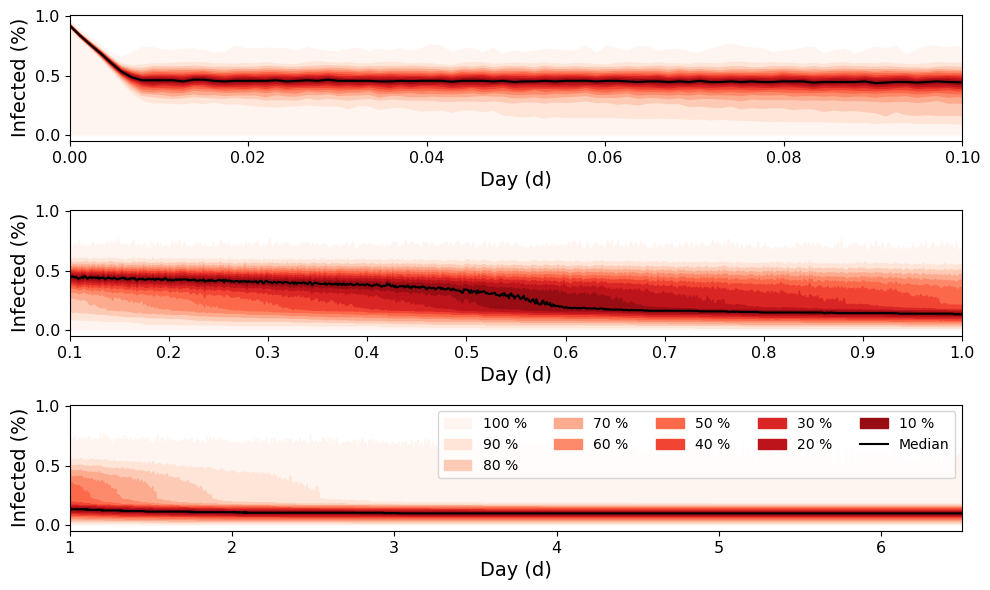

In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(10,6), layout='constrained')


# for ax in (ax1, ax2, ax3):
#     ax.plot(np.arange(0,data_len,1)/step_time, SDist[:,half],color='k')
#     legend_elements = []
#     for i in range(half):
#         ax.fill_between(np.arange(0,data_len,1)/step_time, SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))
#         percentile = 100/n1*i
#         legend_elements.append(Patch(color=colormap(i/half), label=f'{100-percentile*2:00.0f} %'))

#     legend_elements.append(Line2D([0], [0], color='k', label='Median'))

#     # ax.set_ylim(0, 0.7)
#     ax.tick_params(labelsize=11.5, direction='out', top=False, right=False)
#     ax.set_xlabel('Day (d)', fontsize=14)
#     ax.set_ylabel('Infected (%)', fontsize=14)
#     # ax.set_yticks([0, .1, .2, .3, .4, .5, .6, .7])
#     # ax.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70])
#     # ax.grid()
# ax3.legend(handles=legend_elements, loc='upper right', ncol=5)

# ax1.set_xlim(0, 0.1)
# ax2.set_xlim(0.1, 1)
# ax3.set_xlim(1, 6.5)


# fig.tight_layout()


(0.0, 6.5)

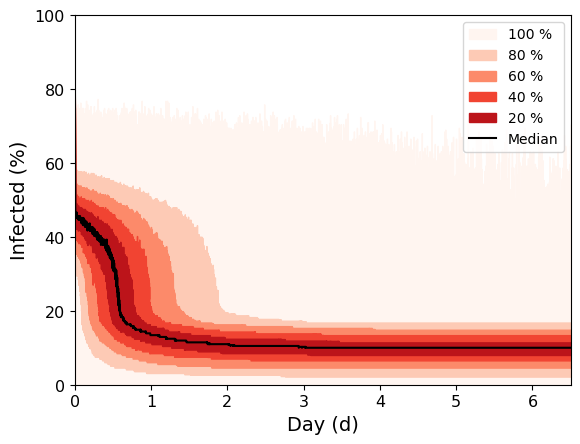

In [24]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,data_len,1)/step_time, SDist[:,half],color='k')
legend_elements = []
for i in range(0, half, 2):
    ax.fill_between(np.arange(0,data_len,1)/step_time, SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))
    percentile = 100/n1*i
    legend_elements.append(Patch(color=colormap(i/half), label=f'{100-percentile*2:00.0f} %'))

legend_elements.append(Line2D([0], [0], color='k', label='Median'))

# ax.set_ylim(0, 0.7)
ax.tick_params(labelsize=11.5, direction='out', top=False, right=False)
ax.set_xlabel('Day (d)', fontsize=14)
ax.set_ylabel('Infected (%)', fontsize=14)
# ax.set_xscale('log')
ax.legend(handles=legend_elements)
ax.set_yticks([i/10 for i in range(0, 11, 2)], labels=[str(i) for i in range(0, 101, 20)])
ax.set_ylim(0, 1)
ax.set_xlim(0, 6.5)
# ax.set_yticks([0, .1, .2, .3, .4, .5, .6, .7])
# ax.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70])
# ax.grid()

# Stationary density

In [11]:
main_df = pd.read_csv('./density_by_rate.dat', sep='\s+', names=['t', 'irate', 'idens'])
rates = np.unique(main_df['irate'])
df_data = pd.DataFrame(columns=["x", "y", "yerr"])
for rate in rates:
    last_values = main_df[main_df['irate'] == rate]['idens']
    # display(last_values)
    # df = pd.DataFrame({"x": [float(keyname)]*len(last_values), "y": (last_values)})
    df = pd.DataFrame({"x": [rate], "y": [np.mean(last_values)], "yerr": [np.std(last_values)]})
    df_data = pd.concat([df_data, df], ignore_index=True)
        

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_131140/1353301697.py:1: SyntaxWarning: invalid escape sequence '\s'
  main_df = pd.read_csv('./density_by_rate.dat', sep='\s+', names=['t', 'irate', 'idens'])
/tmp/ipykernel_131140/1353301697.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_data = pd.concat([df_data, df], ignore_index=True)


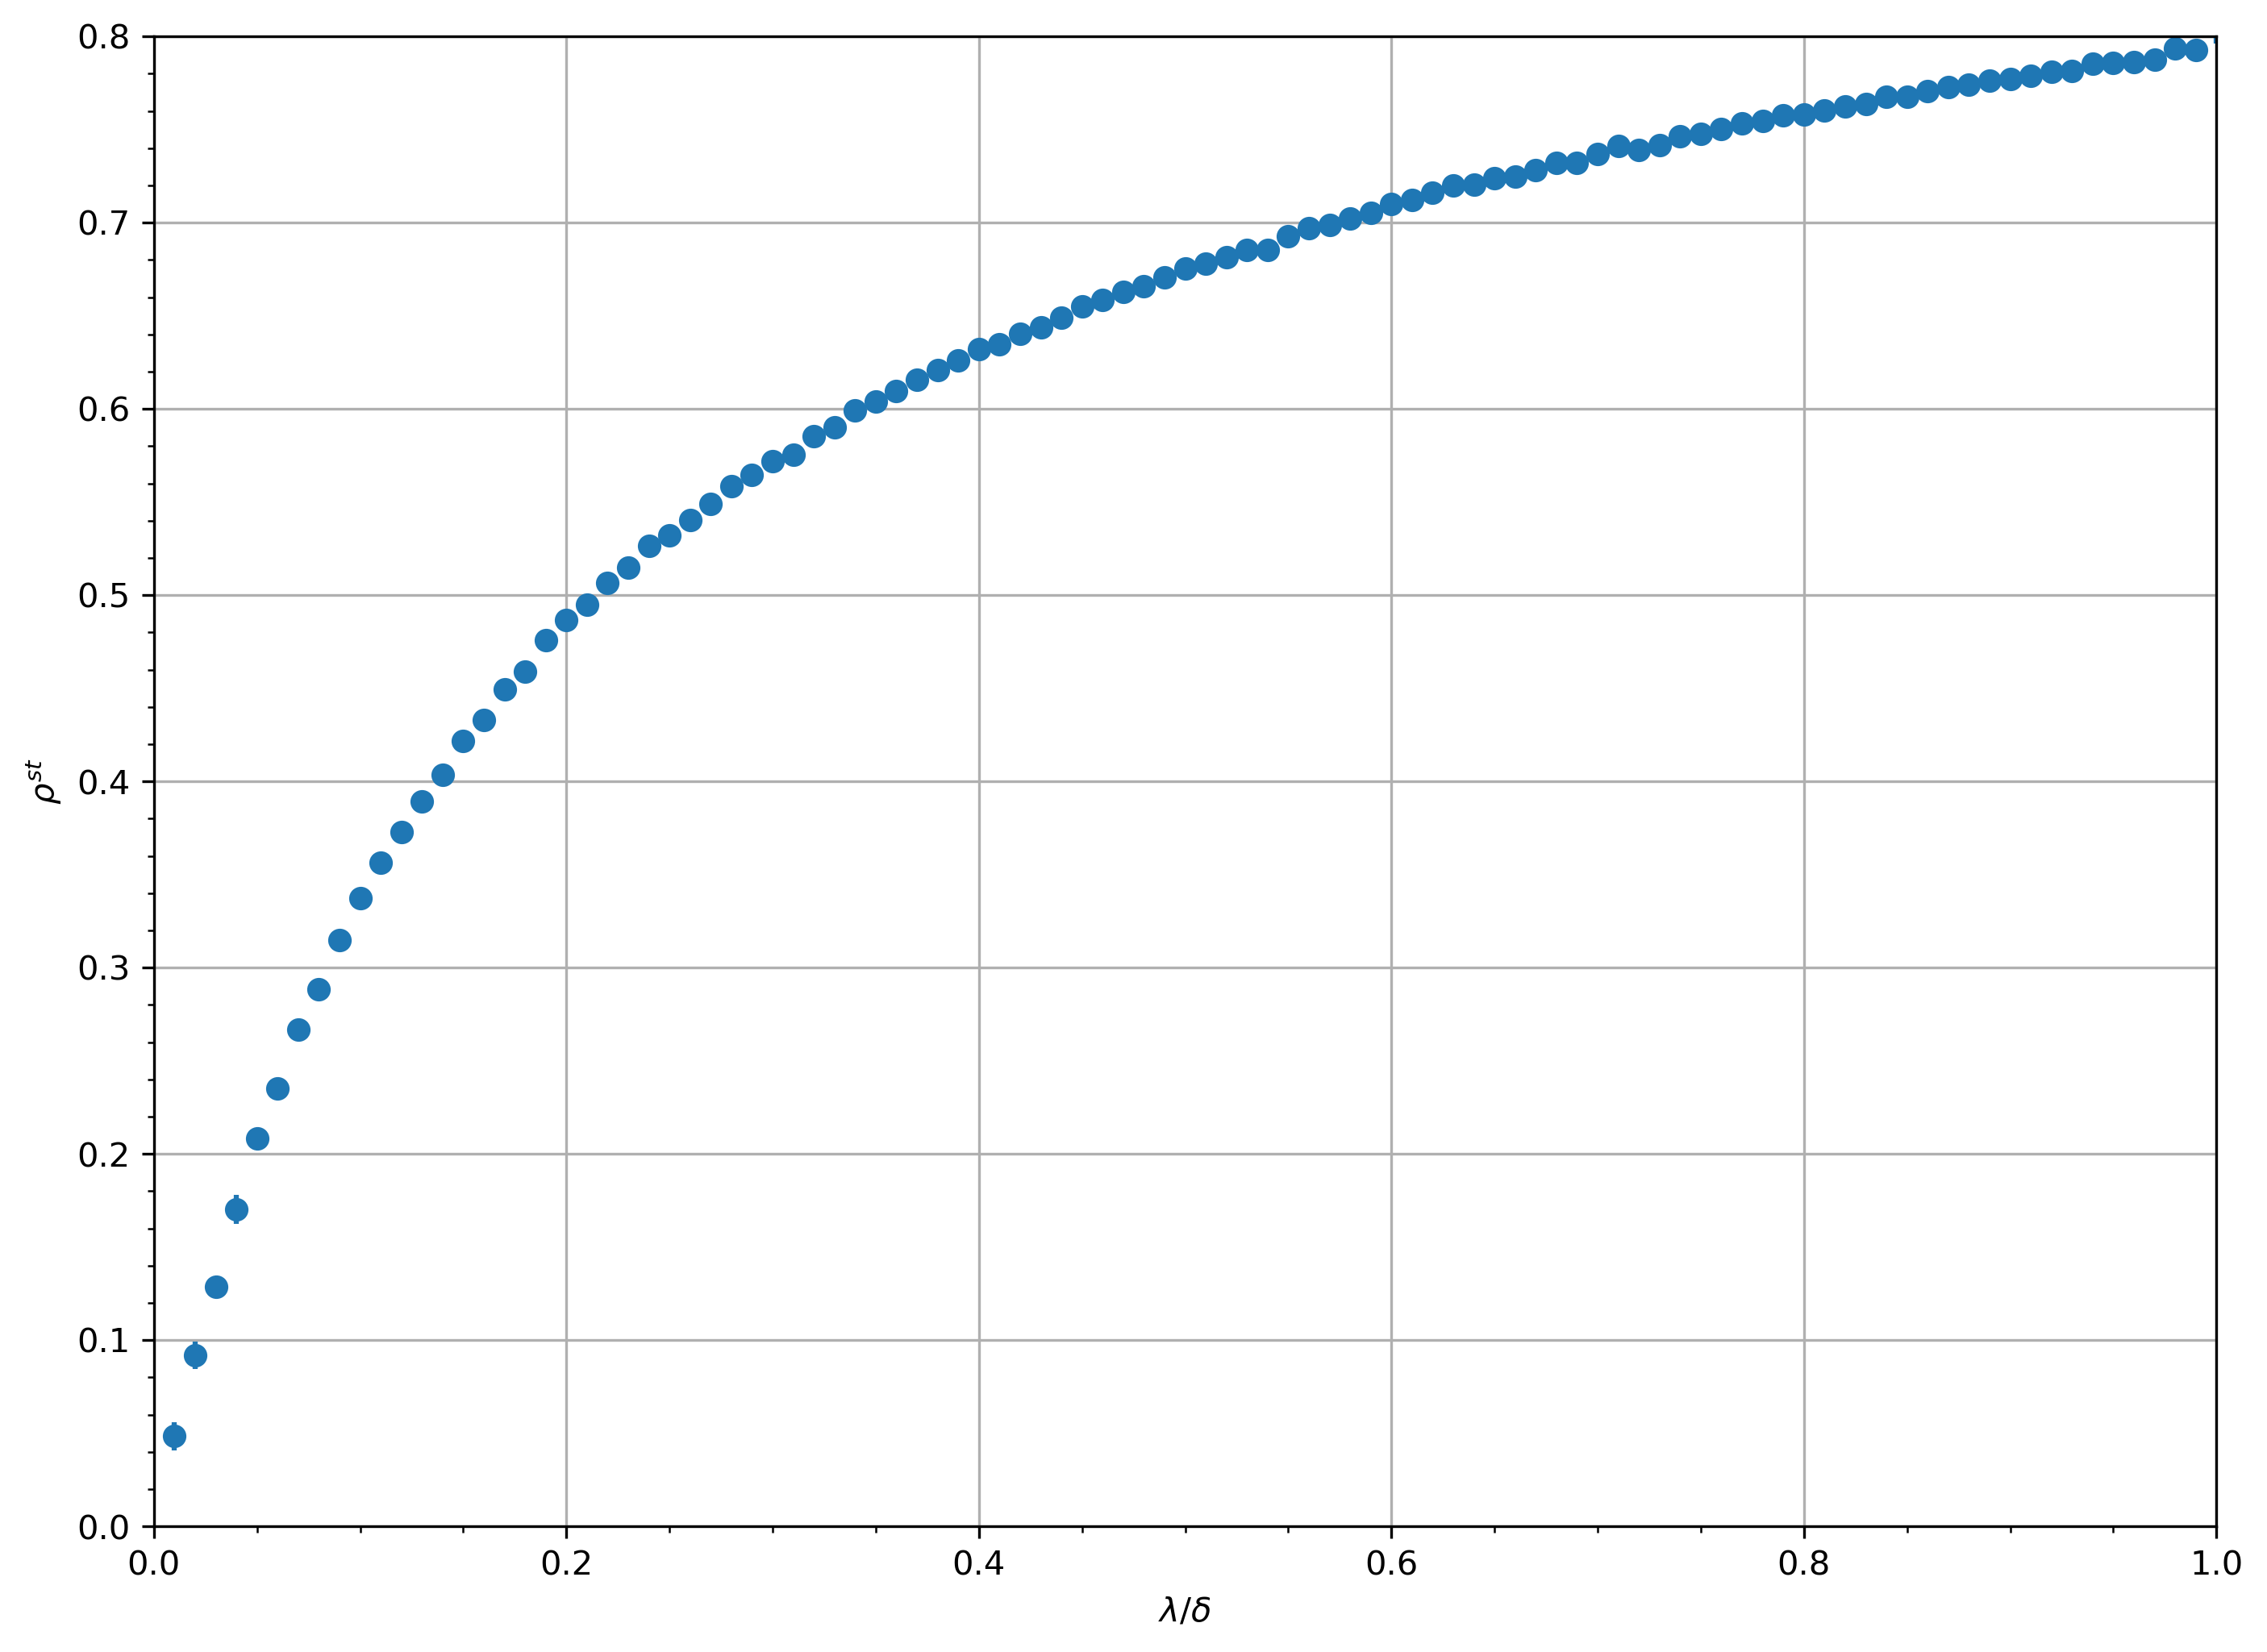

In [12]:
# set_gnuplot_style()
fig, ax = plt.subplots(figsize=(11, 8), dpi=300)
df_data = df_data.sort_values('x')
ax.minorticks_on()
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.8)
ax.errorbar(df_data['x'], df_data['y'], yerr=df_data['yerr'], marker='o', linestyle='none')
# ax.scatter(df_data['x'], df_data['y'], marker='o')
ax.set_xlabel(r'$\lambda/\delta$')
ax.set_ylabel(r'$\rho^{st}$')
ax.grid()
plt.show()

In [6]:
dfs2={}

for i in tqdm(range(10000)):
    infection_rate = (i//100+1)/100
    recovery_rate = 1
    keyname = f'{infection_rate/100:.3f}'
    seed = i%100+1
    if (keyname not in dfs2):
        dfs2[keyname] = []
    df = pd.read_csv(f'./output-lambdadelta/stats-I={infection_rate:10.5f}-R={recovery_rate:10.5f}-S={seed:5d}.dat', sep='    ', header=None, usecols=[0, 3], names=['t', 'irate', 'rrate', 'idens'], engine='python')
    dfs2[keyname].append(df)
        

100%|██████████| 10000/10000 [00:24<00:00, 415.32it/s]


In [7]:
df_data2 = pd.DataFrame(columns=["x", "y", "yerr"])
for keyname in tqdm(dfs.keys()):
    last_values = np.array([x.iloc[-1]['idens'] for x in dfs[keyname]])
    last_values = last_values[last_values > 0.0001]
    # display(last_values)
    # df = pd.DataFrame({"x": [float(keyname)]*len(last_values), "y": (last_values)})
    df = pd.DataFrame({"x": [float(keyname)], "y": [np.mean(last_values)], "yerr": [np.std(last_values)]})
    df_data2 = pd.concat([df_data2, df], ignore_index=True)


  0%|          | 0/100 [00:00<?, ?it/s]/home/adria/miniconda3/envs/epidemics-tfg/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/adria/miniconda3/envs/epidemics-tfg/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/adria/miniconda3/envs/epidemics-tfg/lib/python3.12/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/adria/miniconda3/envs/epidemics-tfg/lib/python3.12/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/adria/miniconda3/envs/epidemics-tfg/lib/python3.12/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divid

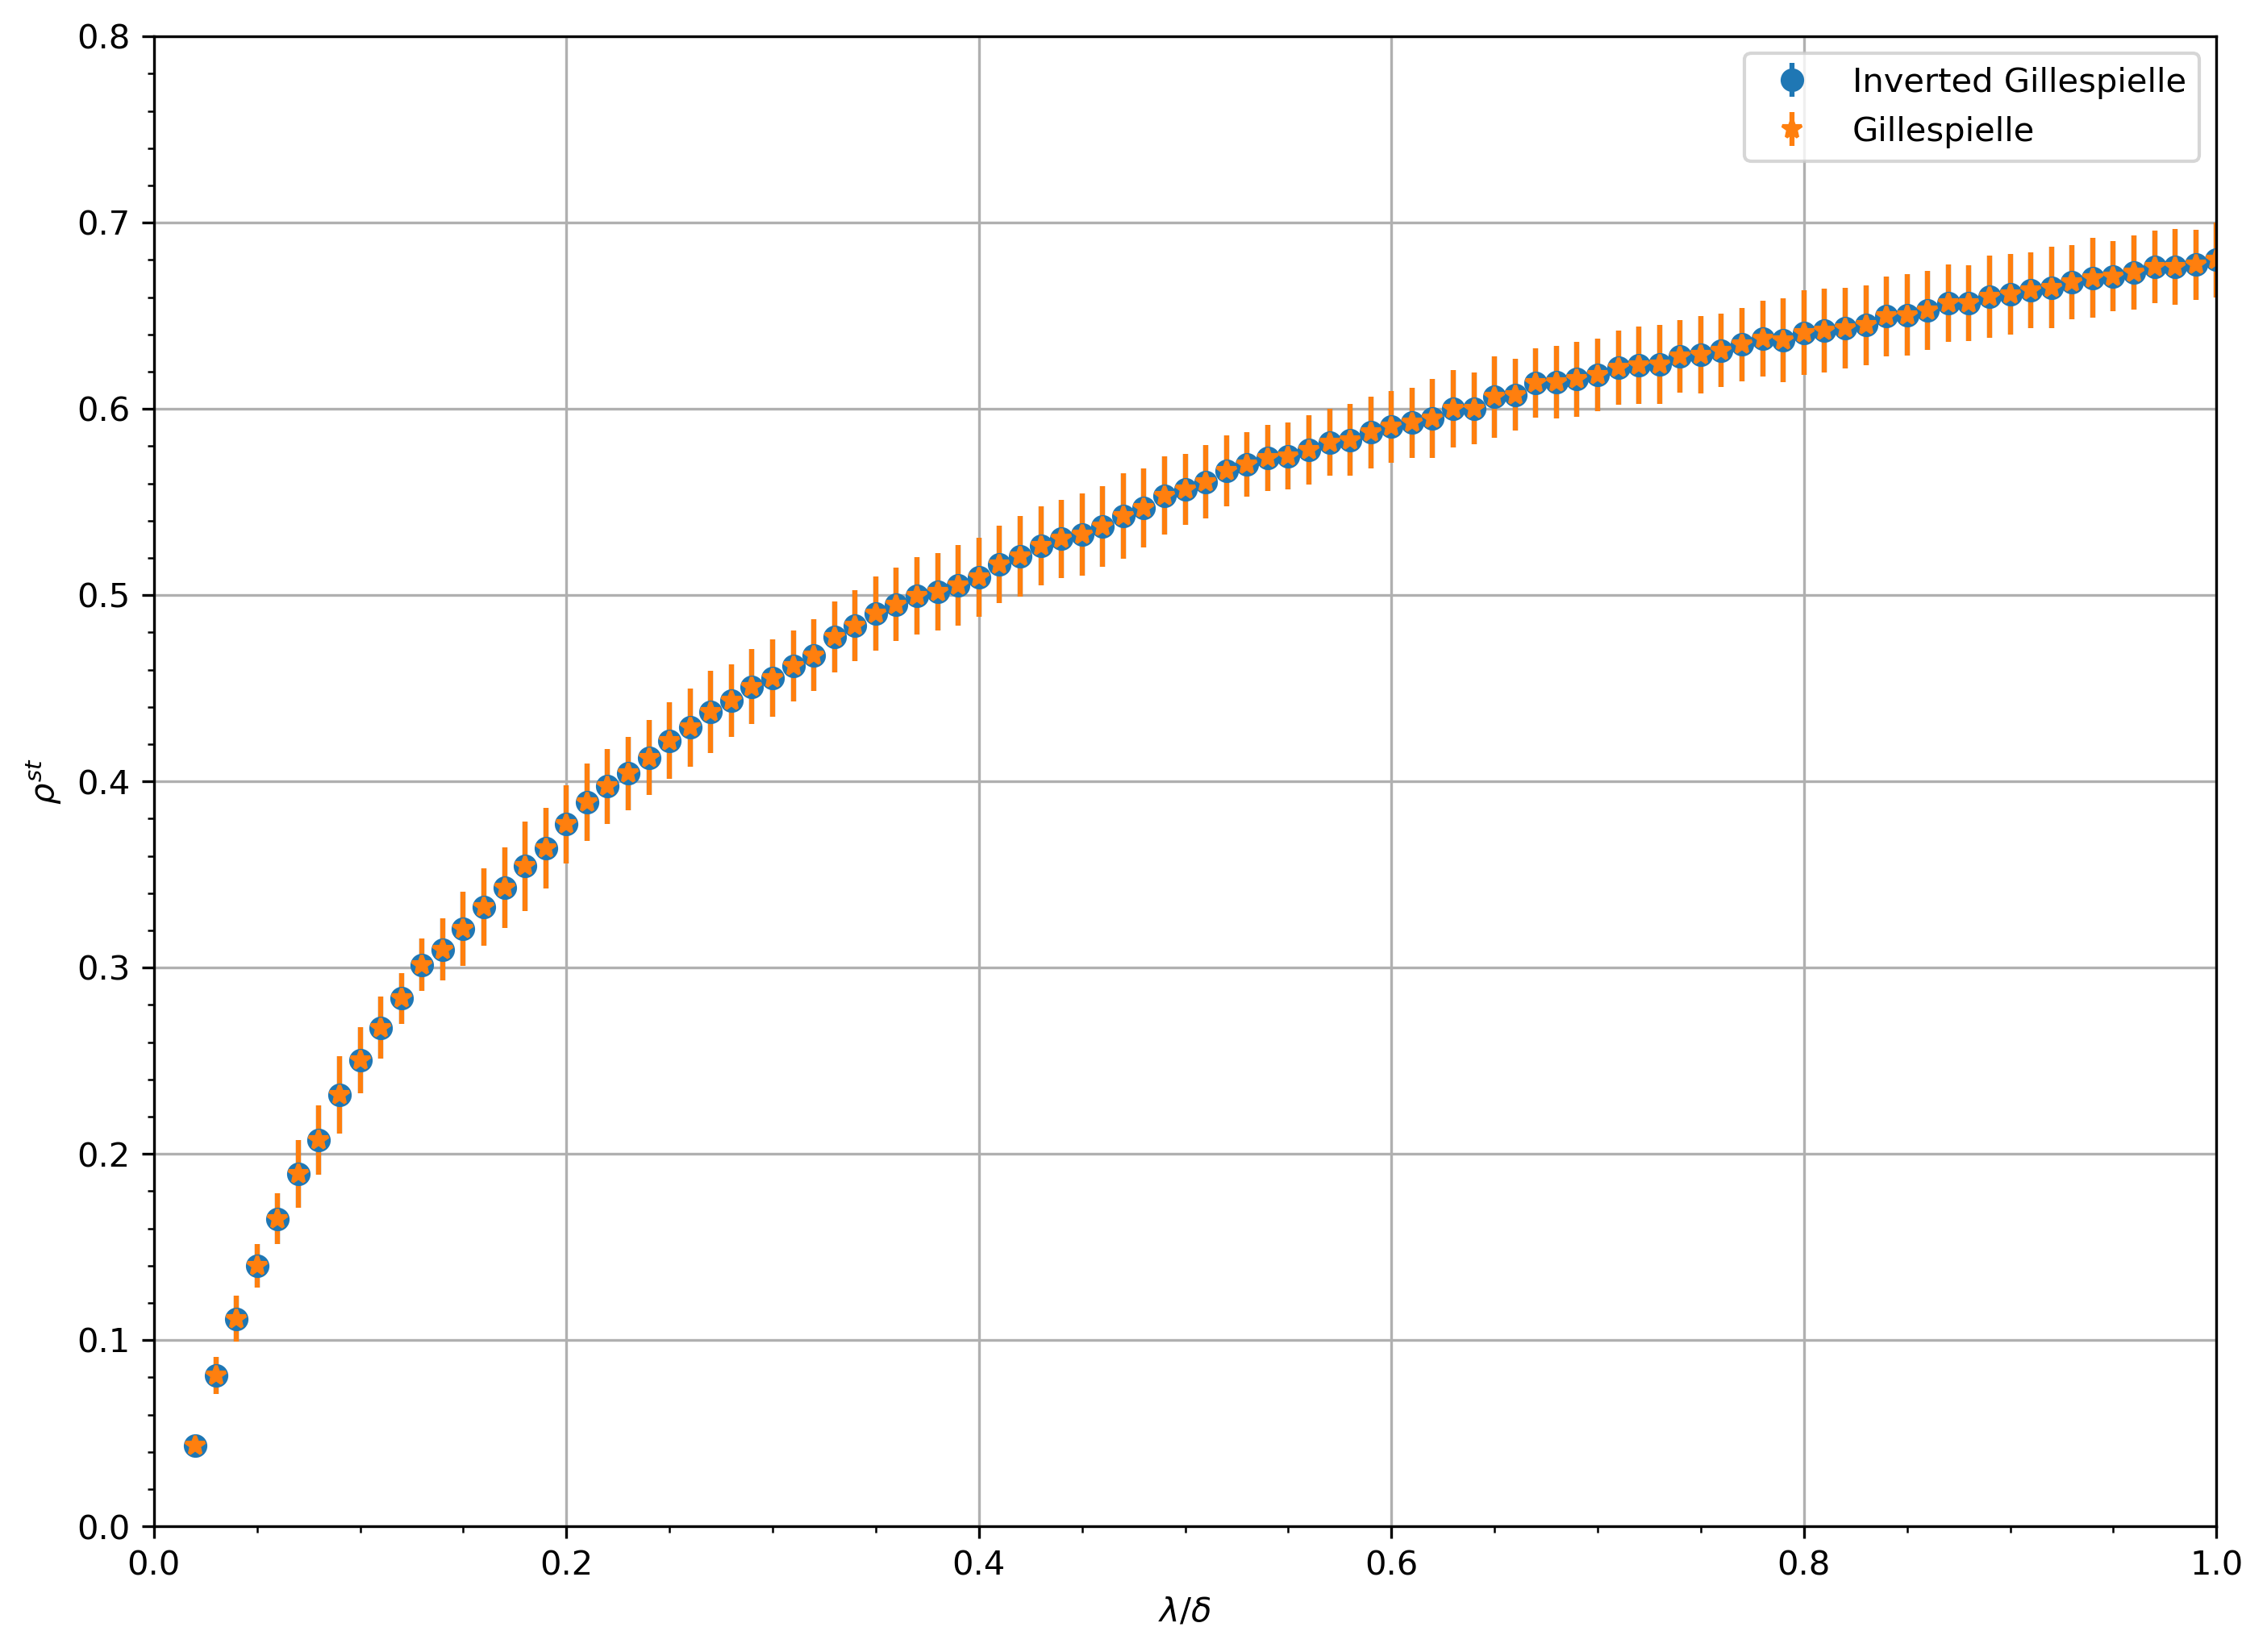

In [8]:
# set_gnuplot_style()
fig, ax = plt.subplots(figsize=(11, 8), dpi=300)
df_data2 = df_data2.sort_values('x')
ax.minorticks_on()
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.8)
ax.errorbar(df_data['x'], df_data['y'], yerr=df_data['yerr'], marker='o', linestyle='none', label='Inverted Gillespielle')
ax.errorbar(df_data2['x'], df_data2['y'], yerr=df_data2['yerr'], marker='*', linestyle='none', label='Gillespielle')
# ax.scatter(df_data['x'], df_data['y'], marker='o')
ax.legend()
ax.set_xlabel(r'$\lambda/\delta$')
ax.set_ylabel(r'$\rho^{st}$')
ax.grid()
plt.show()